In [1]:
import numpy as np 
import xarray as xr 
import MJO_E3SM_util as mjo
import pandas as pd 
import matplotlib.pyplot as plt 
import pickle
%load_ext autoreload
%autoreload 2

In [3]:
# check if int(CRM + PBL) = SEF
f2d = '/pscratch/sd/l/linyaoly/MJO_E3SM_data/regridded_data/control/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h1.0005-01-01-00000.nc_regridded.nc'
f3d = '/pscratch/sd/l/linyaoly/MJO_E3SM_data/regridded_data/control/3D/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h2.0005-01-01-00000.nc_regridded.nc'

ds2d = xr.open_dataset(f2d)
ds3d = xr.open_dataset(f3d)


In [2]:
import glob
files_path = '/pscratch/sd/l/linyaoly/MJO_E3SM_data/regridded_data/control'
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))
ds2d = xr.open_mfdataset(nc_files[-200:])

files_path = '/pscratch/sd/l/linyaoly/MJO_E3SM_data/regridded_data/control/3D'
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))
ds3d = xr.open_mfdataset(nc_files[-200:])


In [39]:
SEF = (ds2d['LHFLX'].sel(lat=slice(-20,20)) + ds2d['SHFLX'].sel(lat=slice(-20,20))).mean(dim=['lat', 'lon']).resample(time='D').mean(dim='time').compute() # [time]

Q = (ds3d['DDSE_CRM_ALT'] + ds3d['DQLV_CRM_ALT'] + ds3d['DDSE_PBL'] + ds3d['DQLV_PBL'] - ds3d['DDSE_QRL'] - ds3d['DDSE_QRS']).sel(lat=slice(-20,20)).mean(dim=['lat', 'lon']).resample(time='D').mean(dim='time').compute() # [time, lev]

# Q_crm = (ds3d['DDSE_CRM'] + ds3d['DQLV_CRM'] + ds3d['DDSE_PBL'] + ds3d['DQLV_PBL'] - ds3d['DDSE_QRL'] - ds3d['DDSE_QRS']).sel(lat=slice(-20,20)).mean(dim=['lat', 'lon']).resample(time='D').mean(dim='time') # [time, lev]

tend = (ds3d['DDSE_TOT'] + ds3d['DQLV_TOT'] ).sel(lat=slice(-20,20)).mean(dim=['lat', 'lon']).resample(time='D').mean(dim='time').compute() # [time, lev]


qr = (ds3d['DDSE_QRL'] + ds3d['DDSE_QRS'] ).sel(lat=slice(-20,20)).mean(dim=['lat', 'lon']).resample(time='D').mean(dim='time').compute() # [time, lev]

dyn = (ds3d['DDSE_DYN'] + ds3d['DQLV_DYN'] ).sel(lat=slice(-20,20)).mean(dim=['lat', 'lon']).resample(time='D').mean(dim='time').compute() # [time, lev]


p = ds3d['lev']  # dataarray
dp = np.zeros(len(p))
dp[1:] = p[1:].values - p[0:-1].values
dp[0] = dp[1]  # hPa
dp = xr.DataArray(dp, dims='lev', coords={'lev': p})

intQ = (Q * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

inttend = (tend * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

intqr = (qr * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

intdyn = (dyn * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

# intQ_crm = (Q_crm * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]


In [40]:
# SEF = SEF.compute()
# intQ = intQ.compute()

inttend = inttend.compute()
intqr = intqr.compute()
intdyn = intdyn.compute()

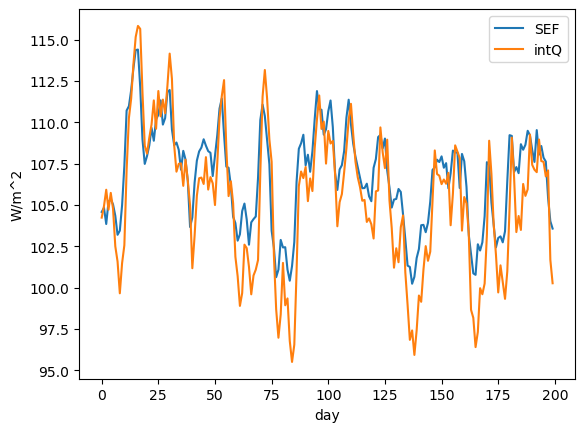

In [36]:
plt.plot(SEF, label='SEF')
plt.plot(intQ, label='intQ')
# plt.plot(inttend, label='tendency')
plt.xlabel('day')
plt.ylabel('W/m^2')
plt.legend()

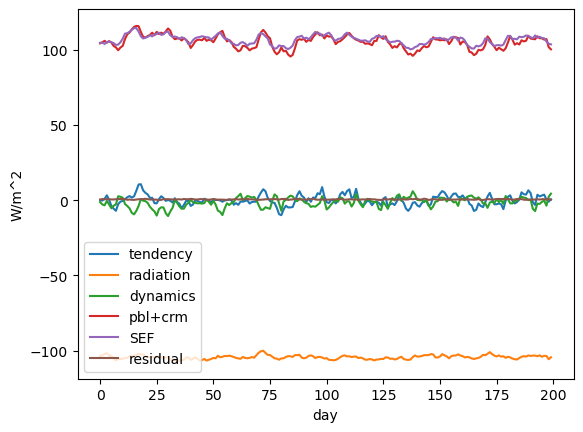

In [43]:
plt.plot(inttend, label='tendency')
plt.plot(intqr, label='radiation')
plt.plot(intdyn, label='dynamics')
plt.plot(intQ, label='pbl+crm')
plt.plot(SEF, label='SEF')

resi = inttend - intQ - intqr - intdyn  

plt.plot(resi, label='residual')
# plt.title('SEF - intQ')
plt.ylabel('W/m^2')
plt.xlabel('day')
plt.legend()

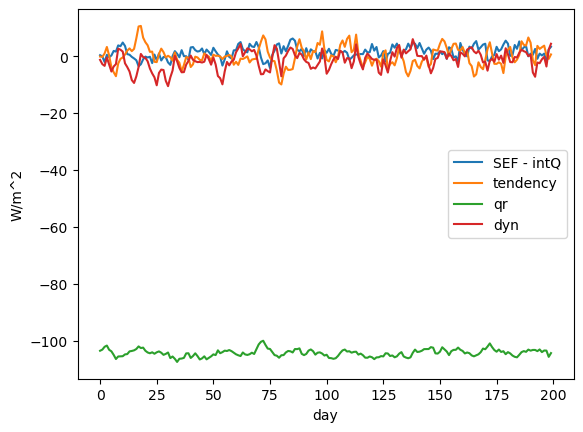

In [41]:
# diff
diff = SEF - intQ
plt.plot(diff, label='SEF - intQ')
plt.plot(inttend, label='tendency')
plt.plot(intqr, label='qr')
plt.plot(intdyn, label='dyn')
# plt.title('SEF - intQ')
plt.ylabel('W/m^2')
plt.xlabel('day')
plt.legend()

In [5]:
ds3d

<xarray.Dataset>
Dimensions:       (lat: 90, lon: 180, nbnd: 2, time: 1, lev: 60, ilev: 61,
                   lwband: 16, swband: 14)
Coordinates:
  * lat           (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon           (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * time          (time) object 0005-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/52)
    lat_bnds      (lat, nbnd) float64 ...
    lon_bnds      (lon, nbnd) float64 ...
    gw            (lat) float64 ...
    area          (lat, lon) float64 ...
    CLDICE        (time, lev, lat, lon) float32 ...
    CLDLIQ        (time, lev, lat, lon) float32 ...
    ...            ...
    nsbase        int32 ...
    nscur         (time) int32 ...
    nsteph        (time) int32 ...
    sol_tsi       (time) float64 ...
    time_bnds     (time, nbnd) object ...
    time_written  (time) |S8 ...
Attributes: (12/26)
    ne:                        30
    fv_nphys:                  2
    title:                     EAM History file information
    source:                    E3SM Atmosphere Model
    source_id:                 75e954ad3f
    product:                   model-output
    ...                        ...
    remap_hostname:            login02
    remap_version:             5.1.4
    NCO:                       netCDF Operators version 5.1.4 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  /global/homes/l/linyaoly/MJO_E3SM/remap/map_ne...
    input_file:                /global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3...

In [25]:
def get_comp_4(comp):
    comp5 = {}
    comp5['mse'] = comp['dse'] + comp['qlv']
    comp5['tendency'] = comp['dtdse'] + comp['dtqlv']
    comp5['crmpbl'] = comp['crm_dse'] + comp['crm_qlv'] + comp['pbl_dse'] + comp['pbl_qlv']
    comp5['dyn'] = comp['dyn_dse'] + comp['dyn_qlv']
    comp5['qr'] = comp['qr']

    return comp5

def get_comp_5_new(comp):
    comp8 = {}
    comp8['mse'] = comp['dse'] + comp['qlv']
    comp8['tendency'] = comp['dtdse'] + comp['dtqlv']
    comp8['tendency_d'] = comp['dtdse'] 
    comp8['tendency_m'] = comp['dtqlv']
    comp8['crmpbl_d'] = comp['crm_dse'] + comp['pbl_dse'] 
    comp8['crmpbl_m'] = comp['crm_qlv'] + comp['pbl_qlv']
    comp8['dyn_d'] = comp['dyn_dse'] 
    comp8['dyn_m'] = comp['dyn_qlv']
    comp8['qr'] = comp['qr']

    return comp8

In [26]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM_data/regridded_data/'
case_dir = 'control'
# case_dir = 'FIX_QRT'

In [27]:
develop_uncertainty = {}
develop_uncertainty['Tendency'] = []
develop_uncertainty['CRMPBL'] = []
develop_uncertainty['Radiation'] = []
develop_uncertainty['Dynamics'] = []

for lat_lim in [5, 10, 15]:
    for kmax in [7, 9, 11]:
        for Tlow in [90, 100, 110, 150]:
            for Thig in [10, 20, 30]:
                flg = str(lat_lim)+'_'+str(kmax)+'_'+str(Tlow)+'_'+str(Thig)
                com_fn = dirn+'analysis/local_MSE_budget/composite_local_MSE_budget_'+case_dir+flg+'.nc'  
                comp_tmp = xr.open_dataset(com_fn).sel(lat=slice(-lat_lim, lat_lim))
                comp = get_comp_4(comp_tmp)  # [lev, lat, lon]

                local_budget_develop = {}
                p = comp['mse']['lev']  # dataarray
                dp = np.zeros(len(p))
                dp[1:] = p[1:].values - p[0:-1].values
                dp[0] = dp[1]  # hPa

                dp = xr.DataArray(dp, dims='lev', coords={'lev': p})

                # integrate over pressure levels
                comp_int = {}

                for key in comp.keys():
                    comp_int[key] = (comp[key] * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

                for key in comp.keys():
                    local_budget_develop[key] = (comp_int['mse'] * comp_int[key]).mean(dim=['lon', 'lat'])  # domain average
                    
                norm = local_budget_develop['mse'] 
                develop_uncertainty['Tendency'].append(local_budget_develop['tendency'] / norm)
                develop_uncertainty['CRMPBL'].append(local_budget_develop['crmpbl'] / norm)
                develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                develop_uncertainty['Dynamics'].append(local_budget_develop['dyn'] / norm)

tend = develop_uncertainty['Tendency']
convd = develop_uncertainty['CRMPBL'] 
rad = develop_uncertainty['Radiation']
dynd = develop_uncertainty['Dynamics']

tend_av = np.mean(tend)
convd_av = np.mean(convd)
rad_av = np.mean(rad)
dynd_av = np.mean(dynd)

tend_std = np.std(tend)
convd_std = np.std(convd)
rad_std = np.std(rad)
dynd_std = np.std(dynd)

develop_mse = [tend_av, convd_av, rad_av, dynd_av]
develop_mse_std = [tend_std, convd_std, rad_std, dynd_std]  

x4 = ['Tendency', 'CRM+PBL', 'Radiation', 'Dynamics']
x_axis = np.arange(len(x4))



In [28]:
develop_uncertainty = {}
develop_uncertainty['Tendency_dry'] = []
develop_uncertainty['Tendency_moist'] = []
develop_uncertainty['CRMPBL_dry'] = []
develop_uncertainty['CRMPBL_moist'] = []
develop_uncertainty['Radiation'] = []
develop_uncertainty['Dynamics_dry'] = []
develop_uncertainty['Dynamics_moist'] = []

for lat_lim in [5, 10, 15]:
    for kmax in [7, 9, 11]:
        for Tlow in [90, 100, 110, 150]:
            for Thig in [10, 20, 30]:
                flg = str(lat_lim)+'_'+str(kmax)+'_'+str(Tlow)+'_'+str(Thig)
                com_fn = dirn+'analysis/local_MSE_budget/composite_local_MSE_budget_'+case_dir+flg+'.nc'  
                comp_tmp = xr.open_dataset(com_fn).sel(lat=slice(-lat_lim, lat_lim))
                comp = get_comp_5_new(comp_tmp)

                local_budget_develop = {}
                p = comp['mse']['lev']  # dataarray
                dp = np.zeros(len(p))
                dp[1:] = p[1:].values - p[0:-1].values
                dp[0] = dp[1]  # hPa

                dp = xr.DataArray(dp, dims='lev', coords={'lev': p})

                # integrate over pressure levels
                comp_int = {}

                for key in comp.keys():
                    comp_int[key] = (comp[key] * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

                for key in comp.keys():
                    local_budget_develop[key] = (comp_int['mse'] * comp_int[key]).mean(dim=['lon', 'lat'])  # domain average
           
                norm = local_budget_develop['mse'] 
                develop_uncertainty['Tendency_dry'].append(local_budget_develop['tendency_d'] / norm)
                develop_uncertainty['Tendency_moist'].append(local_budget_develop['tendency_m'] / norm)
                develop_uncertainty['CRMPBL_dry'].append(local_budget_develop['crmpbl_d'] / norm)
                develop_uncertainty['CRMPBL_moist'].append(local_budget_develop['crmpbl_m'] / norm)
                develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                develop_uncertainty['Dynamics_dry'].append(local_budget_develop['dyn_d'] / norm)
                develop_uncertainty['Dynamics_moist'].append(local_budget_develop['dyn_m'] / norm)

tendd = develop_uncertainty['Tendency_dry']
tendm = develop_uncertainty['Tendency_moist']
convd = develop_uncertainty['CRMPBL_dry'] 
convm = develop_uncertainty['CRMPBL_moist'] 
rad = develop_uncertainty['Radiation']
dynd = develop_uncertainty['Dynamics_dry']
dynm = develop_uncertainty['Dynamics_moist']

tendd_av = np.mean(tendd)
tendm_av = np.mean(tendm)
convd_av = np.mean(convd)
convm_av = np.mean(convm)
rad_av = np.mean(rad)
dynd_av = np.mean(dynd)
dynm_av = np.mean(dynm)

tendd_std = np.std(tendd)
tendm_std = np.std(tendm)
convd_std = np.std(convd)
convm_std = np.std(convm)
rad_std = np.std(rad)
dynd_std = np.std(dynd)
dynm_std = np.std(dynm)

develop_dse = [tendd_av, convd_av, rad_av, dynd_av]
develop_dse_std = [tendd_std, convd_std, rad_std, dynd_std]

develop_qlv = [tendm_av, convm_av, 0, dynm_av]
develop_qlv_std = [tendm_std, convm_std, 0, dynm_std]



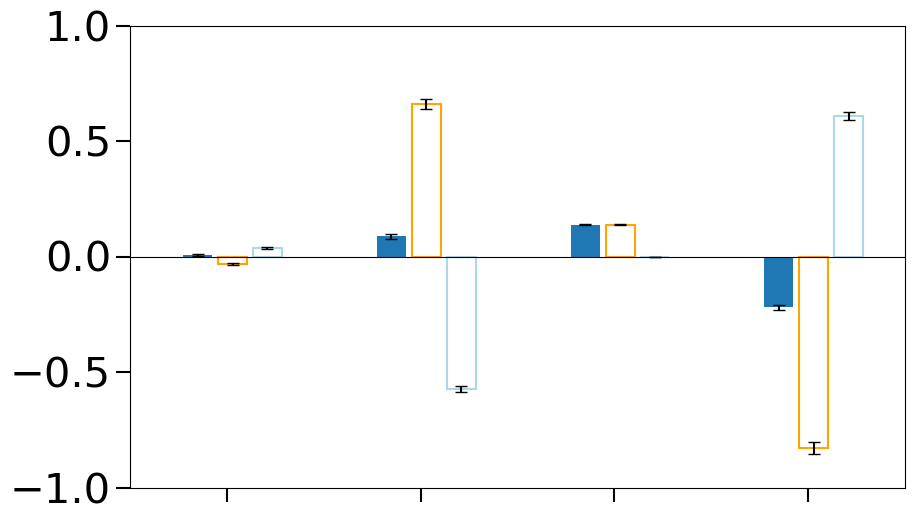

In [35]:
# Define the width of each bar and the spacing between bar groups
bar_width = 0.15
spacing = 0.03  # Space between bars within a group
group_width = (bar_width + spacing) * 2  # Width of each group of bars

fig, ax = plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 30})

# Adjust the position of each bar
for i in range(len(x_axis)):
    ax.bar(x_axis[i] - group_width / 2 + spacing, develop_mse[i], yerr=develop_mse_std[i], capsize=4, ecolor='black', width=bar_width, color='tab:blue')
    ax.bar(x_axis[i] - group_width / 2 + bar_width + 2 * spacing, develop_dse[i], yerr=develop_dse_std[i], capsize=4, ecolor='black', width=bar_width, color='white', edgecolor='orange', linewidth=1.5)
    ax.bar(x_axis[i] - group_width / 2 + 2 * bar_width + 3 * spacing, develop_qlv[i], yerr=develop_qlv_std[i], capsize=4, ecolor='black', width=bar_width, color='white', edgecolor='lightblue', linewidth=1.5)

ax.plot([-1,4],[0,0],'k-',linewidth=0.8)

ax.set_xticks(x_axis, ['','','',''])
# ax.set_ylabel("day" + r'$^{-1}$')
ax.set_ylim([-1.0,1.0])
ax.set_xlim([-0.5,3.5])
# ax.set_yticks([-0.5,-0.5,0,0.5,1])
ax.tick_params(axis='both', which='major', length=10, width=1.5)
plt.savefig('./plots/'+case_dir+'/VI_develop_4terms.pdf', bbox_inches='tight')

In [30]:
develop_uncertainty = {}
develop_uncertainty['Tendency'] = []
develop_uncertainty['CRMPBL'] = []
develop_uncertainty['Radiation'] = []
develop_uncertainty['Dynamics'] = []

for lat_lim in [5, 10, 15]:
    for kmax in [7, 9, 11]:
        for Tlow in [90, 100, 110, 150]:
            for Thig in [10, 20, 30]:
                flg = str(lat_lim)+'_'+str(kmax)+'_'+str(Tlow)+'_'+str(Thig)
                com_fn = dirn+'analysis/local_MSE_budget/composite_local_MSE_budget_'+case_dir+flg+'.nc'  
                comp_tmp = xr.open_dataset(com_fn).sel(lat=slice(-lat_lim, lat_lim))
                comp = get_comp_4(comp_tmp)

                local_budget_develop = {}
                p = comp['mse']['lev']  # dataarray
                dp = np.zeros(len(p))
                dp[1:] = p[1:].values - p[0:-1].values
                dp[0] = dp[1]  # hPa

                dp = xr.DataArray(dp, dims='lev', coords={'lev': p})

                # integrate over pressure levels
                comp_int = {}

                for key in comp.keys():
                    comp_int[key] = (comp[key] * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

                for key in comp.keys():
                    local_budget_develop[key] = (comp_int['tendency'] * comp_int[key]).mean(dim=['lon', 'lat'])  # domain average
           
                norm = local_budget_develop['tendency'] 
                develop_uncertainty['Tendency'].append(local_budget_develop['tendency'] / norm)
                develop_uncertainty['CRMPBL'].append(local_budget_develop['crmpbl'] / norm)
                develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                develop_uncertainty['Dynamics'].append(local_budget_develop['dyn'] / norm)

tend = develop_uncertainty['Tendency']
convd = develop_uncertainty['CRMPBL'] 
rad = develop_uncertainty['Radiation']
dynd = develop_uncertainty['Dynamics']

tend_av = np.mean(tend)
convd_av = np.mean(convd)
rad_av = np.mean(rad)
dynd_av = np.mean(dynd)

tend_std = np.std(tend)
convd_std = np.std(convd)
rad_std = np.std(rad)
dynd_std = np.std(dynd)

propagation_mse = [tend_av, convd_av, rad_av, dynd_av]
propagation_mse_std = [tend_std, convd_std, rad_std, dynd_std]  

x4 = ['Tendency', 'CRM+PBL', 'Radiation', 'Dynamics']
x_axis = np.arange(len(x4))



In [31]:
develop_uncertainty = {}
develop_uncertainty['Tendency_dry'] = []
develop_uncertainty['Tendency_moist'] = []
develop_uncertainty['CRMPBL_dry'] = []
develop_uncertainty['CRMPBL_moist'] = []
develop_uncertainty['Radiation'] = []
develop_uncertainty['Dynamics_dry'] = []
develop_uncertainty['Dynamics_moist'] = []

for lat_lim in [5, 10, 15]:
    for kmax in [7, 9, 11]:
        for Tlow in [90, 100, 110, 150]:
            for Thig in [10, 20, 30]:
                flg = str(lat_lim)+'_'+str(kmax)+'_'+str(Tlow)+'_'+str(Thig)
                com_fn = dirn+'analysis/local_MSE_budget/composite_local_MSE_budget_'+case_dir+flg+'.nc'  
                comp_tmp = xr.open_dataset(com_fn).sel(lat=slice(-lat_lim, lat_lim))
                comp = get_comp_5_new(comp_tmp)

                local_budget_develop = {}
                p = comp['mse']['lev']  # dataarray
                dp = np.zeros(len(p))
                dp[1:] = p[1:].values - p[0:-1].values
                dp[0] = dp[1]  # hPa

                dp = xr.DataArray(dp, dims='lev', coords={'lev': p})

                # integrate over pressure levels
                comp_int = {}

                for key in comp.keys():
                    comp_int[key] = (comp[key] * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

                for key in comp.keys():
                    local_budget_develop[key] = (comp_int['tendency'] * comp_int[key]).mean(dim=['lon', 'lat'])  # domain average
           
                norm = local_budget_develop['tendency'] 
                develop_uncertainty['Tendency_dry'].append(local_budget_develop['tendency_d'] / norm)
                develop_uncertainty['Tendency_moist'].append(local_budget_develop['tendency_m'] / norm)
                develop_uncertainty['CRMPBL_dry'].append(local_budget_develop['crmpbl_d'] / norm)
                develop_uncertainty['CRMPBL_moist'].append(local_budget_develop['crmpbl_m'] / norm)
                develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                develop_uncertainty['Dynamics_dry'].append(local_budget_develop['dyn_d'] / norm)
                develop_uncertainty['Dynamics_moist'].append(local_budget_develop['dyn_m'] / norm)

tendd = develop_uncertainty['Tendency_dry']
tendm = develop_uncertainty['Tendency_moist']
convd = develop_uncertainty['CRMPBL_dry'] 
convm = develop_uncertainty['CRMPBL_moist'] 
rad = develop_uncertainty['Radiation']
dynd = develop_uncertainty['Dynamics_dry']
dynm = develop_uncertainty['Dynamics_moist']

tendd_av = np.mean(tendd)
tendm_av = np.mean(tendm)
convd_av = np.mean(convd)
convm_av = np.mean(convm)
rad_av = np.mean(rad)
dynd_av = np.mean(dynd)
dynm_av = np.mean(dynm)

tendd_std = np.std(tendd)
tendm_std = np.std(tendm)
convd_std = np.std(convd)
convm_std = np.std(convm)
rad_std = np.std(rad)
dynd_std = np.std(dynd)
dynm_std = np.std(dynm)

propagation_dse = [tendd_av, convd_av, rad_av, dynd_av]
propagation_dse_std = [tendd_std, convd_std, rad_std, dynd_std]

propagation_qlv = [tendm_av, convm_av, 0, dynm_av]
propagation_qlv_std = [tendm_std, convm_std, 0, dynm_std]



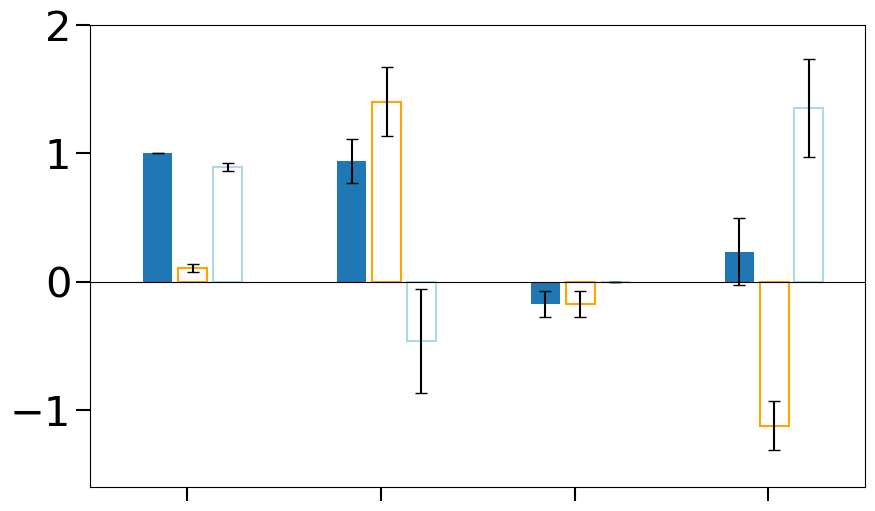

In [36]:
# Define the width of each bar and the spacing between bar groups
bar_width = 0.15
spacing = 0.03  # Space between bars within a group
group_width = (bar_width + spacing) * 2  # Width of each group of bars

fig, ax = plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 30})

# Adjust the position of each bar
for i in range(len(x_axis)):
    ax.bar(x_axis[i] - group_width / 2 + spacing, propagation_mse[i], yerr=propagation_mse_std[i], capsize=4, ecolor='black', width=bar_width, color='tab:blue')
    ax.bar(x_axis[i] - group_width / 2 + bar_width + 2 * spacing, propagation_dse[i], yerr=propagation_dse_std[i], capsize=4, ecolor='black', width=bar_width, color='white', edgecolor='orange', linewidth=1.5)
    ax.bar(x_axis[i] - group_width / 2 + 2 * bar_width + 3 * spacing, propagation_qlv[i], yerr=propagation_qlv_std[i], capsize=4, ecolor='black', width=bar_width, color='white', edgecolor='lightblue', linewidth=1.5)

ax.plot([-1,4],[0,0],'k-',linewidth=0.8)
ax.tick_params(axis='both', which='major', length=10, width=1.5)
ax.set_xticks(x_axis, ['','','',''])
# ax.set_ylabel("day" + r'$^{-1}$')
ax.set_ylim([-1.6,2.0])
ax.set_xlim([-0.5,3.5])
# ax.set_yticks([-1.5,-1,-0.5,0,0.5,1,1.5])
plt.savefig('./plots/'+case_dir+'/VI_propagation_4terms.pdf', bbox_inches='tight')